In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
raw_data = pd.read_csv('inbound.csv')

In [3]:
raw_data['dt'] = pd.to_datetime(raw_data['dt'],format='%Y-%m-%d %H:%M')

In [4]:
raw_data.head()

,dt,passenger_ivr_entrance_count,driver_ivr_entrance_count,finish_ord_cnt,finish_dri_cnt,finish_pas_cnt,act_dri_cnt,act_pas_cnt,avg_strive_suc_assign_orders,sum_strive_suc_assign_orders,...,avg_gmv,sum_gmv,avg_charge_distance,sum_charge_distance,avg_real_order_arrive_time,sum_real_order_arrive_time,avg_subsidy_b,sum_subsidy_b,avg_subsidy_c,sum_subsidy_c
0,2018-06-01,94552,336013,21142569,1590046,15347403.0,1633196,17863491.0,4.724123,23681539.0,...,80.587832,403978423.1,25.456344,127609189.3,1113.044344,5.579576e+09,1.011214,29826938.68,1.106471,32636649.28
1,2018-06-02,85606,285208,20418923,1583517,14682133.0,1615464,15983548.0,4.559649,22152145.0,...,78.387196,380828590.7,25.180955,122336333.3,918.214536,4.460963e+09,0.848034,24958718.79,1.120039,32964172.18
2,2018-06-03,72791,239969,19222263,1536429,13947013.0,1569151,14964497.0,4.430327,20757276.0,...,77.011589,360820089.1,25.015133,117202178.4,863.966977,4.047919e+09,0.756904,20955035.38,1.070729,29643316.45
3,2018-06-04,70817,262650,17518170,1554668,12588405.0,1586320,13569040.0,4.114602,18941403.0,...,71.437307,328858715.2,22.767767,104810163.5,797.760468,3.672458e+09,1.075966,29073617.42,0.867124,23430517.31
4,2018-06-05,68723,262139,18045016,1565881,12883864.0,1599318,13871779.0,4.212913,19531272.0,...,72.404997,335673114.8,22.995526,106608039.1,830.354689,3.849565e+09,0.924312,22516893.67,1.009380,24589217.45


In [5]:
import datetime 
raw_data['day'] = raw_data['dt'].dt.weekday
raw_data['if_weekend'] = raw_data['day'].apply(lambda x: 1 if x == 2 else 0)

In [6]:
raw_data['finish_ord_cnt'].describe()

count    3.540000e+02
mean     1.828888e+07
std      2.317100e+06
min      1.448141e+06
25%      1.706648e+07
50%      1.835566e+07
75%      1.988111e+07
max      2.363327e+07
Name: finish_ord_cnt, dtype: float64

In [7]:
# exlcude data for spring festival
#df = raw_data.loc[raw_data['driver_ivr_entrance_count']>100000]

Text(0.5, 1.0, 'driver ivr by date time')

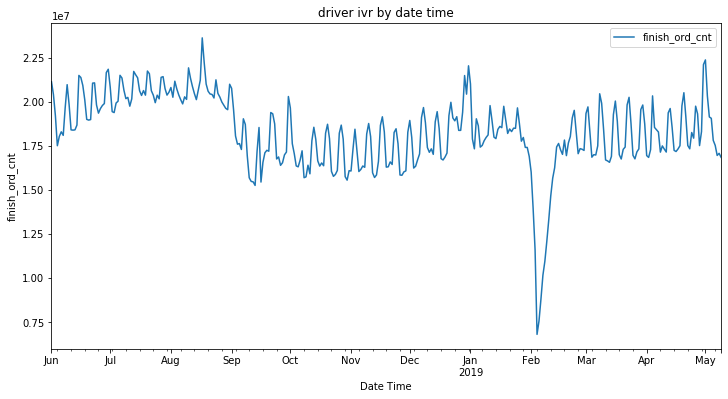

In [8]:
df = raw_data[['dt','finish_ord_cnt','sum_subsidy_c','if_weekend']]
df = raw_data.loc[raw_data['dt']<'2019-5-10']
df.plot(x='dt',y='finish_ord_cnt',figsize=(12,6))
plt.xlabel('Date Time')
plt.ylabel('finish_ord_cnt')
plt.title('driver ivr by date time')

In [9]:
'''
a = df.loc[df['if_weekend']==1,'driver_ivr_entrance_count']
b = df.loc[df['if_weekend']==0,'driver_ivr_entrance_count']
plt.figure(figsize=(10,6))
plt.hist(a,bins=50,alpha=0.5,label='weekend ivr')
plt.hist(b,bins=50,alpha=0.5,label='weekday ivr')
plt.legend(loc='upper right')
plt.xlabel('ivr')
plt.ylabel('count')
plt.show();
'''

"\na = df.loc[df['if_weekend']==1,'driver_ivr_entrance_count']\nb = df.loc[df['if_weekend']==0,'driver_ivr_entrance_count']\nplt.figure(figsize=(10,6))\nplt.hist(a,bins=50,alpha=0.5,label='weekend ivr')\nplt.hist(b,bins=50,alpha=0.5,label='weekday ivr')\nplt.legend(loc='upper right')\nplt.xlabel('ivr')\nplt.ylabel('count')\nplt.show();\n"

In [10]:
'''
df['if_weekend'].value_counts()
'''

"\ndf['if_weekend'].value_counts()\n"

## Clustering-Based Anomaly Detection

In [11]:
df['sum_subsidy_c'] = df['sum_subsidy_c'].fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


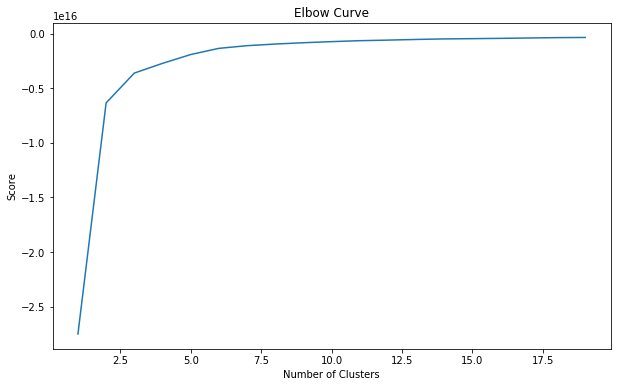

In [12]:
data = df[['finish_ord_cnt','sum_subsidy_c','if_weekend','act_dri_cnt']]
n_cluster = range(1,20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster,scores)
plt.xlabel("Number of Clusters")
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

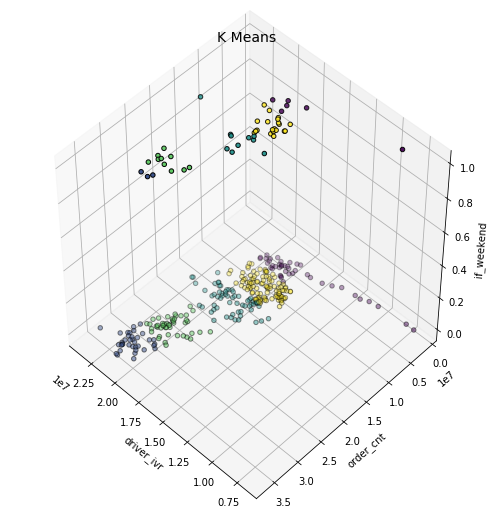

In [15]:
X = df[['finish_ord_cnt','sum_subsidy_c','if_weekend']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
labels = km.labels_
# plotting
fig = plt.figure(1,figsize=(7,7))
ax = Axes3D(fig,rect=[0,0,0.95,1],elev=48,azim=134)
ax.scatter(X.iloc[:,0],X.iloc[:,1],X.iloc[:,2],
          c=labels.astype(np.float),edgecolor="k")
ax.set_xlabel("driver_ivr")
ax.set_ylabel("order_cnt")
ax.set_zlabel("if_weekend")
plt.title("K Means", fontsize=14);

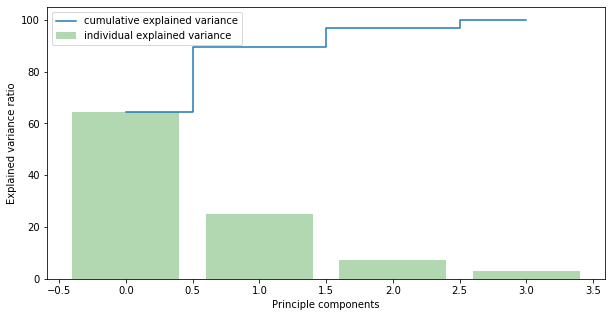

In [16]:
data = df[['finish_ord_cnt','sum_subsidy_c','if_weekend','act_dri_cnt']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std,axis=0)
cov_mat = np.cov(X_std.T)
eig_vals,eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [np.abs(eig_vals[i],eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
tot=sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals,reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) #Cumulative explained variance

plt.figure(figsize=(10,5))
plt.bar(range(len(var_exp)),var_exp,alpha=0.3,align='center',label='individual explained variance', color='g')
plt.step(range(len(cum_var_exp)), cum_var_exp,where='mid',label='cumulative explained variance')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principle components")
plt.legend(loc="best")
plt.show();

In [17]:
# Take useful feature and standardize them
data = df[['finish_ord_cnt','sum_subsidy_c','if_weekend','act_dri_cnt']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [18]:
data.head()

,0,1
0,-1.615716,-0.248259
1,-1.469335,-0.237886
2,-1.030749,-0.258115
3,-0.539558,-0.259206
4,-0.703104,-0.256079


In [19]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[5].predict(data)
df.index = data.index
df['principle_feature1'] = data[0]
df['principle_feature2'] = data[1]
df['cluster'].value_counts()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

0    124
2     82
5     80
1     34
3     14
4      9
Name: cluster, dtype: int64

In [20]:
df.head(2)

,dt,passenger_ivr_entrance_count,driver_ivr_entrance_count,finish_ord_cnt,finish_dri_cnt,finish_pas_cnt,act_dri_cnt,act_pas_cnt,avg_strive_suc_assign_orders,sum_strive_suc_assign_orders,...,sum_real_order_arrive_time,avg_subsidy_b,sum_subsidy_b,avg_subsidy_c,sum_subsidy_c,day,if_weekend,cluster,principle_feature1,principle_feature2
0,2018-06-01,94552,336013,21142569,1590046,15347403.0,1633196,17863491.0,4.724123,23681539.0,...,5.579576e+09,1.011214,29826938.68,1.106471,32636649.28,4,0,2,-1.615716,-0.248259
1,2018-06-02,85606,285208,20418923,1583517,14682133.0,1615464,15983548.0,4.559649,22152145.0,...,4.460963e+09,0.848034,24958718.79,1.120039,32964172.18,5,0,2,-1.469335,-0.237886


In [21]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[5])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


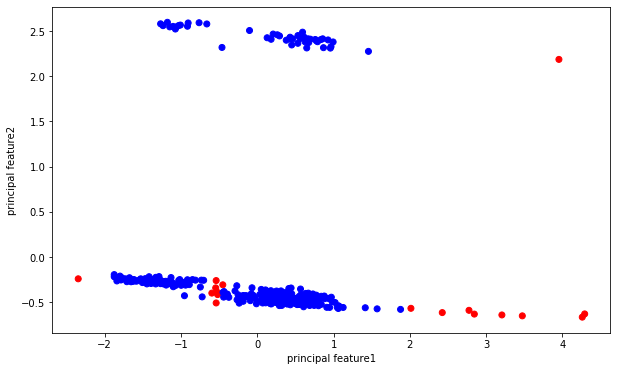

In [22]:
# viz of anomaly with clsuter view
fig,ax = plt.subplots(figsize=(10,6))
colors  = {0:'blue',1:'red'}
ax.scatter(df['principle_feature1'],df['principle_feature2'],c=df['anomaly1'].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [23]:
df.anomaly1.value_counts()

0    326
1     17
Name: anomaly1, dtype: int64

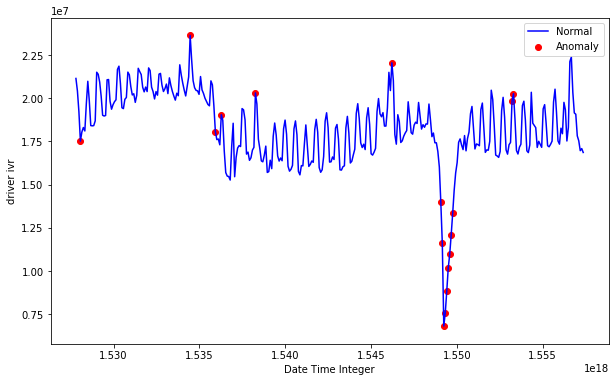

In [24]:
df = df.sort_values('dt') 
df['dt_int'] = df.dt.astype(np.int64)
fig,ax=plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1']==1, ['dt_int','finish_ord_cnt']] # anomaly

ax.plot(df['dt_int'], df['finish_ord_cnt'], color='blue',label='Normal')
ax.scatter(a['dt_int'],a['finish_ord_cnt'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('driver ivr')
plt.legend()
plt.show();

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


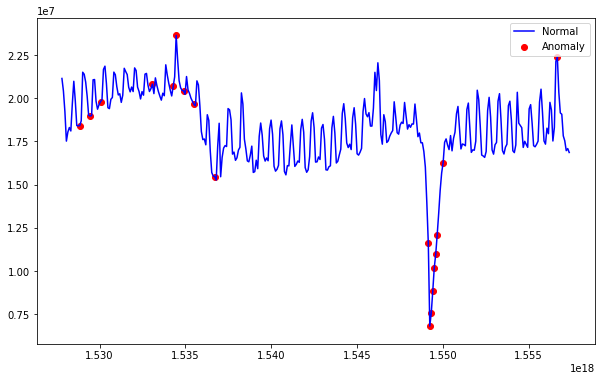

In [25]:
data = df[['finish_ord_cnt','sum_subsidy_c','if_weekend']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
outliers_fraction = 0.05
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))
fig,ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly2']== -1, ['dt_int','finish_ord_cnt']]

ax.plot(df['dt_int'],df['finish_ord_cnt'],color='blue',label='Normal')
ax.scatter(a['dt_int'],a['finish_ord_cnt'],color='red',label='Anomaly')
plt.legend()
plt.show();

## Support Vector Machine-Based Anomaly Detection

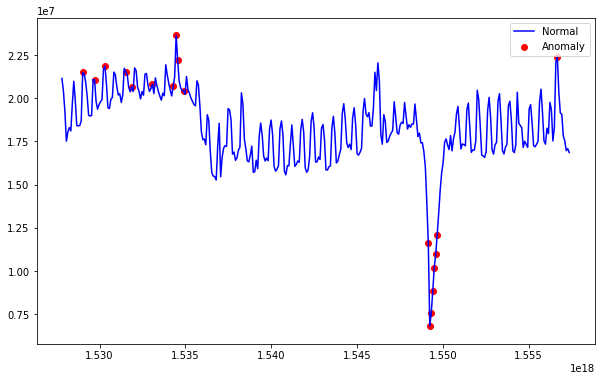

In [26]:
data = df[['finish_ord_cnt','sum_subsidy_c','if_weekend']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

outliers_fraction = 0.05
# train isolation forest
model = OneClassSVM(nu=outliers_fraction,kernel='rbf',gamma=0.01)
model.fit(data)

df['anomaly3'] = pd.Series(model.predict(data))
fig,ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly3']== -1, ['dt_int','finish_ord_cnt']]

ax.plot(df['dt_int'],df['finish_ord_cnt'],color='blue',label='Normal')
ax.scatter(a['dt_int'],a['finish_ord_cnt'],color='red',label='Anomaly')
plt.legend()
plt.show();